In [1]:
import pandas as pd
import pyarrow.parquet as pq
import psutil
import matplotlib.pyplot as plt
import gc

In [2]:
def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 3)  # Return memory usage in GB

print(f"Initial memory usage: {get_memory_usage():.2f} GB")

y_2023 = pq.read_table('./raw_data/y_2023.parquet').to_pandas()

print(f"memory usage after read: {get_memory_usage():.2f} GB")

Initial memory usage: 0.19 GB
memory usage after read: 4.86 GB


In [3]:
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

We won't use the vendor ID, store and forward flag, extra, mta tax, improvement surcharge, congestion surcharge, and airport fee columns, so let's remove those.

In [4]:
for column in ['VendorID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee', 'Airport_fee']:
    del y_2023[column]
print(f"memory usage after column deletions: {get_memory_usage():.2f} GB")
gc.collect()
print(f"memory usage after garbage collection: {get_memory_usage():.2f} GB")

memory usage after column deletions: 2.55 GB
memory usage after garbage collection: 2.62 GB


We can reduce memory usage by changing our integer and float columns from 64 to 32 bit.

In [5]:
y_2023['PULocationID'] = y_2023['PULocationID'].astype('int32')
y_2023['DOLocationID'] = y_2023['DOLocationID'].astype('int32')
y_2023['payment_type'] = y_2023['payment_type'].astype('int32')
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int32         
 6   DOLocationID           int32         
 7   payment_type           int32         
 8   fare_amount            float64       
 9   tip_amount             float64       
 10  tolls_amount           float64       
 11  total_amount           float64       
dtypes: datetime64[us](2), float64(7), int32(3)
memory usage: 3.0 GB


In [6]:
y_2023['passenger_count'] = y_2023['passenger_count'].astype('float32')
y_2023['trip_distance'] = y_2023['trip_distance'].astype('float32')
y_2023['RatecodeID'] = y_2023['RatecodeID'].astype('float32')
y_2023['fare_amount'] = y_2023['fare_amount'].astype('float32')
y_2023['tip_amount'] = y_2023['tip_amount'].astype('float32')
y_2023['tolls_amount'] = y_2023['tolls_amount'].astype('float32')
y_2023['total_amount'] = y_2023['total_amount'].astype('float32')
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38310226 entries, 0 to 38310225
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float32       
 3   trip_distance          float32       
 4   RatecodeID             float32       
 5   PULocationID           int32         
 6   DOLocationID           int32         
 7   payment_type           int32         
 8   fare_amount            float32       
 9   tip_amount             float32       
 10  tolls_amount           float32       
 11  total_amount           float32       
dtypes: datetime64[us](2), float32(7), int32(3)
memory usage: 2.0 GB


In [7]:
y_2023.RatecodeID.value_counts()

RatecodeID
1.0     34891490
2.0      1473727
5.0       217163
99.0      213480
3.0       127504
4.0        77445
6.0           61
Name: count, dtype: int64

Rate codes 1 - 6 are designated by the TLC as standard/airport/negotiated/group rates, but not 99. Unsure what this code represents. What can we determine about trips with rate code 99?

In [8]:
# % of ratecode 99 rides with no tip
100 * len(y_2023.loc[(y_2023.RatecodeID == 99) & (y_2023.tip_amount == 0)]) / len(y_2023.loc[y_2023.RatecodeID == 99])
# 99.95 %

99.95268877646618

In [9]:
y_2023.groupby(['RatecodeID']).trip_distance.mean()

RatecodeID
1.0      2.817362
2.0     17.381987
3.0     16.625427
4.0     23.323414
5.0      6.653451
6.0      1.765246
99.0    14.859373
Name: trip_distance, dtype: float32

In [10]:
y_2023.groupby(['RatecodeID']).fare_amount.mean()

RatecodeID
1.0      16.566458
2.0      67.557449
3.0      83.374687
4.0     105.376038
5.0      69.543091
6.0      47.456226
99.0     33.358036
Name: fare_amount, dtype: float32

Unclear what rate code 99 refers to (maybe a miscellaneous designation). We'll leave the corresponding records as they appear to be valid data.

Next: check for null values.

In [11]:
y_2023.isna().sum()

tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count          1309356
trip_distance                  0
RatecodeID               1309356
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
tip_amount                     0
tolls_amount                   0
total_amount                   0
dtype: int64

In [12]:
y_2023.loc[y_2023.passenger_count.isna()].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount
2995023,2023-01-01 00:02:40,2023-01-01 00:30:36,NaN,0.00,NaN,142,79,0,20.129999,0.00,0.0,24.129999
2995024,2023-01-01 00:57:48,2023-01-01 01:12:34,NaN,0.00,NaN,237,263,0,12.000000,2.55,0.0,21.549999
2995025,2023-01-01 00:55:37,2023-01-01 01:00:41,NaN,0.86,NaN,24,41,0,12.800000,2.14,0.0,16.440001
2995026,2023-01-01 00:43:47,2023-01-01 00:56:12,NaN,5.36,NaN,88,229,0,24.510000,4.28,0.0,32.790001
2995027,2023-01-01 00:34:00,2023-01-01 00:51:00,NaN,6.03,NaN,232,263,0,32.299999,7.26,0.0,43.560001


Replace null values for passenger count and ratecode with column modes (both are 1).

In [13]:
y_2023['passenger_count'].fillna(1, inplace=True)
y_2023['RatecodeID'].fillna(1, inplace=True)
y_2023.isna().sum()

/tmp/ipykernel_20015/712782289.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y_2023['passenger_count'].fillna(1, inplace=True)
/tmp/ipykernel_20015/712782289.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
tolls_amount             0
total_amount             0
dtype: int64

The missing data appears to correspond to the same records other than airport fees. Later we'll replace null values for passengers and rate codes with the column mode. We'll remove the store and forward flag, congestion surcharge, and airport fee columns.

Remove some of the bad data:
- non-2023 dates
- trips with distance 0 or over 100 miles

In [14]:
print(f"memory usage before drop: {get_memory_usage():.2f} GB")

y_2023 = y_2023[(y_2023['tpep_pickup_datetime'] > pd.Timestamp('2023-01-01')) &(y_2023.tpep_pickup_datetime < pd.Timestamp('2024-01-01')) & (y_2023.tpep_dropoff_datetime > pd.Timestamp('2023-01-01')) & (y_2023.tpep_dropoff_datetime < pd.Timestamp('2024-01-01')) & (y_2023['trip_distance'] != 0) & (y_2023['trip_distance'] < 100)]

print(f"memory usage after drop: {get_memory_usage():.2f} GB")

gc.collect()

print(f"memory usage after garbage collection: {get_memory_usage():.2f} GB")


memory usage before drop: 2.21 GB
memory usage after drop: 3.02 GB
memory usage after garbage collection: 3.02 GB


Add features for trip duration, day of pickup, and hour of pickup.

In [15]:
y_2023['duration'] = ((y_2023.tpep_dropoff_datetime - y_2023.tpep_pickup_datetime) / pd.Timedelta(minutes=1)).round(2)
y_2023['day'] = y_2023.tpep_pickup_datetime.dt.day_name()
y_2023['hour'] = y_2023.tpep_pickup_datetime.dt.hour
gc.collect()

0

In [16]:
y_2023.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,duration,day,hour
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,161,141,2,9.3,0.00,0.0,14.300000,8.43,Sunday,0
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,43,237,1,7.9,4.00,0.0,16.900000,6.32,Sunday,0
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,48,238,1,14.9,15.00,0.0,34.900002,12.75,Sunday,0
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,138,7,1,12.1,0.00,0.0,20.850000,9.62,Sunday,0
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,107,79,1,11.4,3.28,0.0,19.680000,10.83,Sunday,0


We can remove the pickup and dropoff datetime columns now that we've extracted the data we want from them.

In [17]:
del y_2023['tpep_pickup_datetime']
del y_2023['tpep_dropoff_datetime']

Add a feature for tip percent, keeping in mind that tips aren't recorded for cash payments (designated by payment type 2).

In [18]:
y_2023['tip_pct'] = (100 * y_2023.tip_amount / (y_2023.total_amount - y_2023.tip_amount)).round(2)

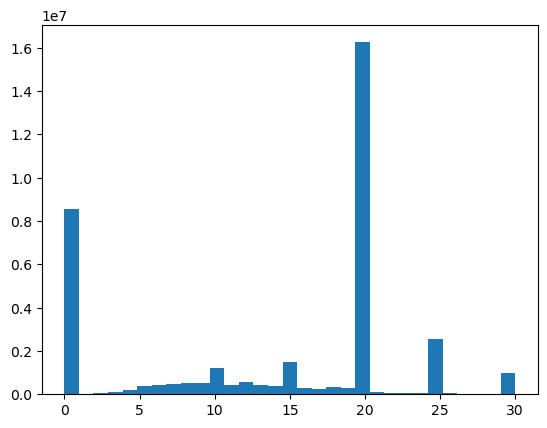

In [19]:
plt.hist(y_2023.tip_pct, bins = 31, range = (0, 30))
plt.show()

Looking at a histogram of tip percentages, we see a clear delineation at 5% increments, which we expect from a suggested tip option for e-payment.

Next: add speed and $ / min features. S / min is our KPI for measuring profitability, determined by (fare + tip - gas) / time, where the price of gas is based on an average NYC price of $3.50 / gallon.

In [20]:
y_2023['speed'] = (60 * y_2023.trip_distance / y_2023.duration).round(2).astype('float32')
y_2023['dollar_min'] = ((y_2023.fare_amount + y_2023.tip_amount - 0.15 * y_2023.trip_distance) / y_2023.duration).round(2).astype('float32')
print(f"memory usage: {get_memory_usage():.2f} GB")
gc.collect()
print(f"memory usage after garbage collection: {get_memory_usage():.2f} GB")

memory usage: 4.03 GB
memory usage after garbage collection: 4.03 GB


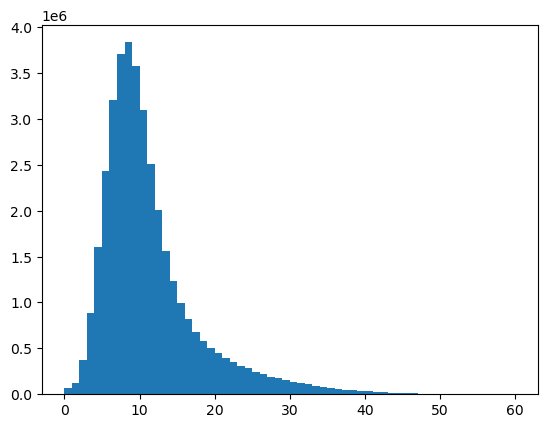

In [21]:
plt.hist(y_2023.speed, bins = 60, range = (0, 60))
plt.show()

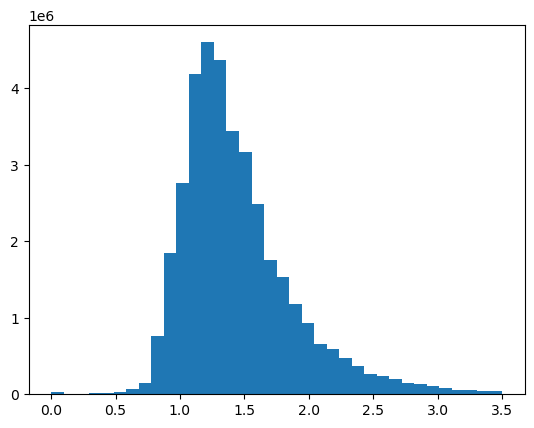

In [22]:
plt.hist(y_2023.dollar_min, bins = 36, range = (0, 3.5))
plt.show()

Distribution of speed and dollars per minute follow a left-skewed distribution, with dollars per minute highly correlated with speed.

Remove bad data:
- trips with unknown pickup or dropoff locations (designated as zones 264 and 265)
- 0 and negative fares
- trips with duration less than 1 minute or over 6 hours
- trips with speed > 60 mph
- negative tips

In [23]:
print(f"memory usage before drop: {get_memory_usage():.2f} GB")

y_2023 = y_2023[(y_2023.PULocationID < 264) & (y_2023.DOLocationID < 264) & (y_2023.fare_amount > 0) & (y_2023.total_amount > 0) & (y_2023.duration >= 1) & (y_2023.duration <= 360) & (y_2023.speed < 60) & (y_2023.tip_amount >= 0)]

print(f"memory usage after drop: {get_memory_usage():.2f} GB")

gc.collect()

print(f"memory usage after garbage collection: {get_memory_usage():.2f} GB")

memory usage before drop: 4.04 GB
memory usage after drop: 4.32 GB
memory usage after garbage collection: 4.40 GB


In [24]:
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36490653 entries, 0 to 38310225
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  float32
 1   trip_distance    float32
 2   RatecodeID       float32
 3   PULocationID     int32  
 4   DOLocationID     int32  
 5   payment_type     int32  
 6   fare_amount      float32
 7   tip_amount       float32
 8   tolls_amount     float32
 9   total_amount     float32
 10  duration         float64
 11  day              object 
 12  hour             int32  
 13  tip_pct          float32
 14  speed            float32
 15  dollar_min       float32
dtypes: float32(10), float64(1), int32(4), object(1)
memory usage: 2.7+ GB


Add a column designating a valid ride with a value of 1 for filtering purposes.

In [30]:
y_2023['valid_ride'] = 1
y_2023['valid_ride'] = y_2023['valid_ride'].astype('int32')

In [31]:
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36490653 entries, 0 to 38310225
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  float32
 1   trip_distance    float32
 2   RatecodeID       float32
 3   PULocationID     int32  
 4   DOLocationID     int32  
 5   payment_type     int32  
 6   fare_amount      float32
 7   tip_amount       float32
 8   tolls_amount     float32
 9   total_amount     float32
 10  duration         float64
 11  day              object 
 12  hour             int32  
 13  tip_pct          float32
 14  speed            float32
 15  dollar_min       float32
 16  valid_ride       int32  
dtypes: float32(10), float64(1), int32(5), object(1)
memory usage: 2.9+ GB


Convert our Pandas Dataframe back to Parquet for loading in a dashboard.

In [32]:
y_2023.to_parquet('./raw_data/y_2023_clean.parquet', compression=None, index=False)

In [33]:
y_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36490653 entries, 0 to 38310225
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  float32
 1   trip_distance    float32
 2   RatecodeID       float32
 3   PULocationID     int32  
 4   DOLocationID     int32  
 5   payment_type     int32  
 6   fare_amount      float32
 7   tip_amount       float32
 8   tolls_amount     float32
 9   total_amount     float32
 10  duration         float64
 11  day              object 
 12  hour             int32  
 13  tip_pct          float32
 14  speed            float32
 15  dollar_min       float32
 16  valid_ride       int32  
dtypes: float32(10), float64(1), int32(5), object(1)
memory usage: 2.9+ GB
